# Initial Conditions

Next, we will explore the creation of the initial conditions. In our previous example models, the initial conditions were generated using model output fields generated as monthly averages. Here, will explore a different approach using existing pickups

First, import packages to visualize the model fields here:

In [1]:
# import modules for computation and plotting
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

# import pertinent tools from eccoseas
from eccoseas.ecco import pickup
from eccoseas.ecco import grid
from eccoseas.downscale import horizontal

Next, define the location of the data for this mo. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the data directory
data_dir = '../../../data/alaskan_north_slope'

## Constructing the Initial Conditions
For this model, we use the pickup

### Step 1: Download the ECCO Files
To begin, I downloaded the model pickups for the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/input_init). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2008):

| Data | Metadata |
| -------- | --------- |
|pickup.0000000001.data|pickup.0000000001.meta|

In addition to the data above, we also need the grid information. We read this in from https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_grid:

- tile001.mitgrid
- tile002.mitgrid
- tile003.mitgrid
- tile004.mitgrid
- tile005.mitgrid
- AngleCS.data
- AngleSN.data
- hFacC.data


I stored these fields in the data directory define above.

### Step 2: Read in the pickup file
To read in the pickup, we will rely on the `pickup` module from the `eccoseas.ecco`:

In [3]:
global_pickup_faces, global_pickup_metadata = \
    pickup.read_ecco_pickup_file_to_faces(os.path.join(data_dir,'pickup.0000000001'), llc=270)

/Users/mike/opt/anaconda3/envs/mitgcm/lib/python3.10/site-packages/eccoseas/ecco/grid.py:59: RuntimeWarning: invalid value encountered in cast
  field_faces[i][nr,:,:] = grid


The function to read the pickup file returns both the data as well as the metadata. Let's have a look at the fields in the data:

In [4]:
print(global_pickup_metadata)

{'nDims': 2, 'dimList': [[270, 1, 270], [3510, 1, 3510]], 'dataprec': 'float64', 'nrecords': 403, 'timeStepNumber': 78841, 'timeInterval': 94609200.0, 'nFlds': 11, 'fldList': ['Uvel', 'Vvel', 'Theta', 'Salt', 'GuNm1', 'GuNm2', 'GvNm1', 'GvNm2', 'EtaN', 'dEtaHdt', 'EtaH']}


Next, we need to convert the fields to the ECCO tiles

In [5]:
global_pickup_tiles = {}
for field_name in global_pickup_metadata['fldList']:
    field_faces = global_pickup_faces[field_name]
    field_tiles = grid.ecco_faces_to_tiles(field_faces, llc=270, dim=3)
    global_pickup_tiles[field_name] = field_tiles

### Step 3: Read in the Regional Model Grid and Mask
Since the model grid has already been generated for this model (see note in Overview), we will read it in from the nc file:

In [6]:
# define the parameters that will be used in the data file
ds = nc4.Dataset('../../../data/alaskan_north_slope/NorthSlope_ncgrid.nc')
XC = ds.variables['XC'][:, :]
YC = ds.variables['YC'][:, :]
hFacC = ds.variables['HFacC'][:, :, :]
hFacW = ds.variables['HFacW'][:, :, :]
hFacS = ds.variables['HFacS'][:, :, :]
ds.close()

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [7]:
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

In [8]:
Nr = 50

In [9]:
ecco_XC_faces, ecco_YC_faces, ecco_AngleCS_faces, ecco_AngleSN_faces, ecco_hFacC_faces =\
     grid.read_ecco_geometry_to_faces(data_dir,llc=270)

In [10]:
ecco_XC_tiles = grid.ecco_faces_to_tiles(ecco_XC_faces, llc=270, dim=2)
ecco_YC_tiles = grid.ecco_faces_to_tiles(ecco_YC_faces, llc=270, dim=2)
ecco_AngleCS_tiles = grid.ecco_faces_to_tiles(ecco_AngleCS_faces, llc=270, dim=2)
ecco_AngleSN_tiles = grid.ecco_faces_to_tiles(ecco_AngleSN_faces, llc=270, dim=2)
ecco_hFacC_tiles = grid.ecco_faces_to_tiles(ecco_hFacC_faces, llc=270, dim=3)

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. For this model, we need tiles 7 and 8:

In [11]:
# define the tile list
tile_list = [7,8]

Let's verify that these tiles cover our grid:

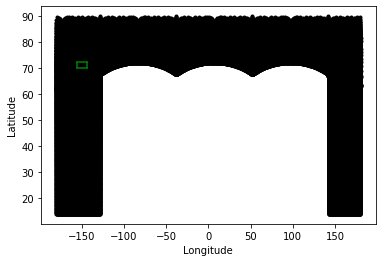

In [12]:
# plot the ECCO tile points
for tile in tile_list:
    plt.plot(ecco_XC_tiles[tile],ecco_YC_tiles[tile],'k.')

# plot the boundary of the regional model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, this model boundary (green) is completely surrounded by the points in tile 7 and 8 (black). We also note that there is extraneous information in points with longitude greater than 0 - I will omit these points as well. Given these observations, now I read in points from just those tiles to use in interpolation:

In [13]:
# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((Nr, total_points))
#ecco_hFacW_points = np.zeros((Nr, total_points))
#ecco_hFacS_points = np.zeros((Nr, total_points))
ecco_mask_points = np.zeros((Nr, total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(Nr):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        #level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        #level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        #ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        #ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_mask_points = ecco_mask_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
#ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
#ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [14]:
# make a file dictionary to loop over
field_names = ['Theta']

Now, read the initial condition fields from the same tiles. Here, we have to confront the weirdness of the ECCO LLC grid

In [15]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in field_names:
    
    if variable_name in ['Theta']:
        f_grid_tiles = global_pickup_tiles[variable_name]
    else:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_2008.nc'))
        u_grid_tiles = ds.variables['UVELMASS'][:,:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_2008.nc'))
        v_grid_tiles = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()

    # create a grid of zeros to fill in
    N = np.shape(f_grid_tiles[1])[-1]*np.shape(f_grid_tiles[1])[-2]
    if variable_name in ['EtaN']:
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((Nr, N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name in ['EtaN']:
            init_grid[0,points_counted:points_counted+N] = \
                 f_grid_tiles[tile_number][0, :, :].ravel()
        elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
            if variable_name == 'UVEL':
                if tile_number<7:
                    for k in range(Nr):
                        init_grid[k,points_counted:points_counted+N] = \
                             u_grid[tile_number][k, :, :].ravel()
                else:
                    for k in range(Nr):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[tile_number][k, :, :].ravel()
            if variable_name == 'VVEL':
                if tile_number<7:
                    for k in range(Nr):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[tile_number][k, :, :].ravel()
                else:
                    for k in range(Nr):
                        init_grid[k,points_counted:points_counted+N] = \
                             -1*u_grid[tile_number][k, :, :].ravel()
        else:
            for k in range(Nr):
                init_grid[k,points_counted:points_counted+N] = \
                     f_grid_tiles[tile_number][k, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]

    # apply some corrections
    if variable_name == 'UVEL':
        for k in range(Nr):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for k in range(Nr):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
    init_grids.append(init_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [ ]:
interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_mask_points, 
                                                       XC, YC, maskC, testing=True)


# output the interpolated grid
#output_file = os.path.join(input_dir,'ics',variable_name+'_IC.bin')
#interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

In [ ]:
plt.pcolormesh(interpolated_grid)
plt.show()

### Step 5 (Revised for the Arctic): Interpolate the Fields onto the Model Grid 

In [ ]:
# # loop through each variable and corresponding ECCO grid
# for variable_name, init_grid in zip(variable_names, init_grids):

#     # print a message to keep track of which variable we are working on
#     # uncomment to use
#     # print('    - Interpolating the '+variable_name+' grid')

#     if variable_name == 'ETAN':
#         model_mask = mask[:1,:,:]
#     else:
#         model_mask = mask

#     interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
#                                                        init_grid, ecco_mask_points, 
#                                                        XC, YC, model_mask)


#     # output the interpolated grid
#     output_file = os.path.join(input_dir,'ics',variable_name+'_IC.bin')
#     interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [ ]:
meta_dict = {'ETAN':[0.1, 0.5, 'viridis', 'm'],
            'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.25, 0.25, 'seismic', 'm'],
            'VVEL':[-0.25, 0.25, 'seismic', 'm']}

Then, I'll create all of the subplots:

In [ ]:
# fig = plt.figure(figsize=(12,8))


# for i in range(len(variable_names)):
#     variable_name = variable_names[i]
    
#     CA_init_grid = np.fromfile(os.path.join(input_dir,'ics',variable_name+'_IC.bin'),'>f4')

#     if variable_name == 'ETAN':
#         CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
#     else:
#         CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
#         CA_init_grid = CA_init_grid[10, :, :] # choose just the surface for plotting
    
#     plt.subplot(2,3,i+1)
#     C = plt.pcolormesh(XC, YC, CA_init_grid,
#                        vmin=meta_dict[variable_names[i]][0],
#                        vmax=meta_dict[variable_names[i]][1],
#                        cmap=meta_dict[variable_names[i]][2])
#     plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

#     if i<5:
#         plt.gca().set_xticklabels([])
#     else:
#         plt.gca().set_xlabel('Longitude')
#     if i%2==1:
#         plt.gca().set_yticklabels([])
#     if i==7:
#         plt.gca().axis('off')
#     if i==2:
#         plt.gca().set_ylabel('Latitude')
#     plt.title(variable_name)

# plt.tight_layout()

# plt.show()

Looks good! Now we need to make our external forcing and boundary conditions before we're ready to run the model.

### Step 7: Run-time considerations
To use the new pickup, be sure to specify `nIter=1` in your `data` file.